In [2]:
# Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
# Importing the cleaned dataset
pd.set_option('display.max_columns', None)
churn_df = pd.read_csv("customer-churn-cleaned.csv")
churn_df.head()

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Checking for missing values if any (just to be sure)
churn_df.isnull().sum()

Senior Citizen       0
Partner              0
Dependents           0
Tenure               0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn                0
dtype: int64

In [5]:
# Checking for class imbalance
churn_df.Churn.value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

In [6]:
# Converting our target variable into 0/1
lb = LabelBinarizer()
churn_df["Churn"] = lb.fit_transform(churn_df["Churn"])
churn_df.head(5)

,Senior Citizen,Partner,Dependents,Tenure,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn
0,No,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,No,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,No,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,No,No,No,45.0,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,No,No,No,2.0,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [7]:
# Making a list of categorical and numerical attributes
num_attributes = ["Tenure", "Monthly Charges", "Total Charges"]
cat_attributes = [column for column in churn_df.columns[:-1] if not column in num_attributes]
print(cat_attributes)

['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


In [8]:
# # Performing SMOTE and random undersampling to solve class imbalance problem
# from imblearn.pipeline import Pipeline
# sampling_pipeline = Pipeline([
#     ("over", SMOTE()),
#     ("under", RandomUnderSampler())
# ])

# X, y = sampling_pipeline.fit_resample(X, y)

In [9]:
# Splitting the dataset in train and test
train_full_set, test_set = train_test_split(churn_df, test_size=0.15, random_state=42, stratify=churn_df["Churn"])
print("Training Samples: ", train_full_set.shape[0])
print("Testing Samples: ", test_set.shape[0])

Training Samples:  5977
Testing Samples:  1055


In [10]:
# Checking for class imbalance here
train_full_set["Churn"].value_counts()

0    4388
1    1589
Name: Churn, dtype: int64

In [11]:
X_train_full = train_full_set.drop("Churn", axis=1)
y_train_full = train_full_set["Churn"]

In [12]:
# Now Splitting the full training dataset again into train and validation
train_set, val_set = train_test_split(train_full_set, test_size=0.2, random_state=42, stratify=train_full_set["Churn"])
print("Train Samples: ", train_set.shape[0])
print("Val Samples: ", val_set.shape[0])

Train Samples:  4781
Val Samples:  1196


In [13]:
# Creating X and y values for each dataset
X_train = train_set.drop("Churn", axis=1)
X_val = val_set.drop("Churn", axis=1)
X_test = test_set.drop("Churn", axis=1)
y_train = train_set["Churn"]
y_val = val_set["Churn"]
y_test = test_set["Churn"]

In [14]:
# Building a columntransformer pipeline for data preprocessing
preprocessing_pipeline = ColumnTransformer([
    ("std_scaler", StandardScaler(), num_attributes),
    ("cat_one_hot", OneHotEncoder(), cat_attributes)
])

In [15]:
# create a K_fold split
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [16]:
# Let's first build a Simple Logistic regression Model
lr_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("lr", LogisticRegression(solver="sag", max_iter=1000, class_weight="balanced") )
])

scores = cross_val_score(lr_pipeline, X_train_full, y_train_full, scoring="roc_auc", cv=cv)

In [17]:
# Creating a function to display scores
def display_scores(scores):
    print("ROC-AUC Scores: ", scores)
    print("ROC-AUC Mean: ", scores.mean())
    print("ROC-AUC SD: ", scores.std())

In [18]:
# Checking out the scores for our Logistic Regression Model
display_scores(scores)

ROC-AUC Scores:  [0.83033732 0.86706136 0.84505939 0.85061997 0.84199637 0.85330618
 0.83399414 0.85207994 0.85581026 0.84034157 0.84060938 0.83349092
 0.86840072 0.86151689 0.83264129]
ROC-AUC Mean:  0.8471510472021809
ROC-AUC SD:  0.012045988570697132


In [ ]:
# Fitting the pipeline on the training data
lr_pipeline.fit(X_train_full, y_train_full)

In [20]:
# a function to print all metrics of results on test set
def print_metrics(prediction):
    print("Accuracy: ", round(accuracy_score(y_test, prediction), 2))
    print("ROC-AUC score: ", round(roc_auc_score(y_test, prediction), 2))
    print("F1-score: ", round(f1_score(y_test, prediction, average="weighted"), 2))
    print("Precision: ", round(precision_score(y_test, prediction, average="weighted"), 2))
    print("Recall: ", round(recall_score(y_test, prediction, average="weighted"), 2))
    print("---------------------------")
    print(confusion_matrix(y_test, prediction))
    print("---------------------------")
    print(classification_report(y_test, prediction))

In [21]:
# Checking the model performance on test data
y_pred_lr = lr_pipeline.predict(X_test)
print_metrics(y_pred_lr)

Accuracy:  0.72
ROC-AUC score:  0.75
F1-score:  0.74
Precision:  0.8
Recall:  0.72
---------------------------
[[537 238]
 [ 55 225]]
---------------------------
              precision    recall  f1-score   support

           0       0.91      0.69      0.79       775
           1       0.49      0.80      0.61       280

    accuracy                           0.72      1055
   macro avg       0.70      0.75      0.70      1055
weighted avg       0.80      0.72      0.74      1055



In [22]:
# Let's now build a Random Forest classifier Model
rf_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("rf", RandomForestClassifier(n_estimators=50, class_weight="balanced") )
])

scores = cross_val_score(rf_pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)

In [23]:
# Checking out the scores for our Random Forest Model
display_scores(scores)

ROC-AUC Scores:  [0.82922183 0.82024082 0.82440777 0.8176498  0.81090865 0.79896933
 0.81238363 0.81664592 0.83754515 0.81393712 0.83016591 0.8114807
 0.80590888 0.81827792 0.82886915]
ROC-AUC Mean:  0.8184408377015551
ROC-AUC SD:  0.009894408914726163


In [ ]:
# Fitting the pipeline on the training data
rf_pipeline.fit(X_train_full, y_train_full)

In [25]:
# Checking the model performance on test data
y_pred_rf = rf_pipeline.predict(X_test)
print_metrics(y_pred_rf)

Accuracy:  0.77
ROC-AUC score:  0.68
F1-score:  0.77
Precision:  0.76
Recall:  0.77
---------------------------
[[679  96]
 [144 136]]
---------------------------
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       775
           1       0.59      0.49      0.53       280

    accuracy                           0.77      1055
   macro avg       0.71      0.68      0.69      1055
weighted avg       0.76      0.77      0.77      1055



In [26]:
# Create a param_grid with values for tuning hyperparameters
rf_param_grid = [{'rf__criterion': ["gini", "entropy"], 'rf__n_estimators': [50, 100, 150, 200], 'rf__class_weight': ['balanced'],
               'rf__max_depth': [4, 6, 8, 10], 'rf__max_features': [8, 10, 12, 14]}]

In [ ]:
# Creating a gridsearchCV for randomforestModel
rf_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("rf", RandomForestClassifier() )
])

grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=cv, scoring="roc_auc", return_train_score=True, n_jobs=-1)
grid_search.fit(X_train_full, y_train_full)

In [28]:
# checking the model's best performing hyperparameters
grid_search.best_params_

{'rf__class_weight': 'balanced',
 'rf__criterion': 'entropy',
 'rf__max_depth': 6,
 'rf__max_features': 12,
 'rf__n_estimators': 200}

In [29]:
# checking the model's best score
grid_search.best_score_

0.8483801926951596

In [30]:
grid_search.best_estimator_[1]

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, max_features=12, n_estimators=200)

In [31]:
# Getting the feature importance of each attribute
feature_importances = grid_search.best_estimator_[1].feature_importances_
feature_importances

array([0.12010466, 0.0621366 , 0.08168823, 0.00292874, 0.0033179 ,
       0.00266401, 0.00237524, 0.00301255, 0.00262638, 0.00143806,
       0.00133436, 0.00265666, 0.00172774, 0.00328347, 0.01964023,
       0.0690796 , 0.00454721, 0.07419715, 0.00425707, 0.00724572,
       0.00894795, 0.00768434, 0.00276418, 0.00305462, 0.00365982,
       0.0012    , 0.04338767, 0.00782533, 0.0067929 , 0.0031802 ,
       0.00695969, 0.00531398, 0.00469833, 0.00421232, 0.00909418,
       0.23344478, 0.02363913, 0.10528118, 0.00461525, 0.00566732,
       0.00428622, 0.00302399, 0.02841473, 0.00259032])

In [32]:
# Selecting the model with best parameters
final_rf_model = grid_search.best_estimator_

# Checking the model performance on test data
y_pred_rf = final_rf_model.predict(X_test)
print_metrics(y_pred_rf)

Accuracy:  0.73
ROC-AUC score:  0.76
F1-score:  0.75
Precision:  0.8
Recall:  0.73
---------------------------
[[551 224]
 [ 56 224]]
---------------------------
              precision    recall  f1-score   support

           0       0.91      0.71      0.80       775
           1       0.50      0.80      0.62       280

    accuracy                           0.73      1055
   macro avg       0.70      0.76      0.71      1055
weighted avg       0.80      0.73      0.75      1055



In [34]:
# Let's first build a K Nearerst Neigbors classifier Model
knn_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("knn", KNeighborsClassifier(n_neighbors=20))
])

scores = cross_val_score(knn_pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)

In [35]:
# Checking out the scores for our K Nearest Neigbors Model
display_scores(scores)

ROC-AUC Scores:  [0.84057036 0.82831673 0.81779    0.83448303 0.81659544 0.80803866
 0.82064461 0.82161765 0.85639455 0.80857281 0.83621027 0.82296644
 0.80869619 0.83693945 0.8305993 ]
ROC-AUC Mean:  0.8258956998985819
ROC-AUC SD:  0.013158117979862558


In [ ]:
# Fitting the pipeline on the training data
knn_pipeline.fit(X_train_full, y_train_full)

In [37]:
# Checking the model performance on test data
y_pred_knn = knn_pipeline.predict(X_test)
print_metrics(y_pred_knn)

Accuracy:  0.78
ROC-AUC score:  0.71
F1-score:  0.78
Precision:  0.77
Recall:  0.78
---------------------------
[[668 107]
 [126 154]]
---------------------------
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       775
           1       0.59      0.55      0.57       280

    accuracy                           0.78      1055
   macro avg       0.72      0.71      0.71      1055
weighted avg       0.77      0.78      0.78      1055



In [44]:
# Create a param_grid with values for tuning hyperparameters
knn_param_grid = [{'knn__n_neighbors': [30, 35, 40, 45, 50],
                    'knn__weights': ['uniform', 'distance'],
                    'knn__metric': ['euclidean', 'manhattan', 'minkowski']
                   }]

In [ ]:
# Creating a gridsearchCV for randomforestModel
knn_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("knn", KNeighborsClassifier() )
])

knn_grid_search = GridSearchCV(knn_pipeline, knn_param_grid, cv=cv, scoring="roc_auc", return_train_score=True, n_jobs=-1)
knn_grid_search.fit(X_train_full, y_train_full)

In [46]:
# checking the model's best performing hyperparameters
knn_grid_search.best_params_

{'knn__metric': 'euclidean', 'knn__n_neighbors': 50, 'knn__weights': 'uniform'}

In [47]:
#  checking the model's best score
knn_grid_search.best_score_

0.8359260953932623

In [48]:
knn_grid_search.best_estimator_[1]

KNeighborsClassifier(metric='euclidean', n_neighbors=50)

In [49]:
# Selecting the model with best parameters
final_knn_model = knn_grid_search.best_estimator_

# Checking the model performance on test data
y_pred_knn = final_knn_model.predict(X_test)
print_metrics(y_pred_knn)

Accuracy:  0.78
ROC-AUC score:  0.72
F1-score:  0.78
Precision:  0.78
Recall:  0.78
---------------------------
[[660 115]
 [116 164]]
---------------------------
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       775
           1       0.59      0.59      0.59       280

    accuracy                           0.78      1055
   macro avg       0.72      0.72      0.72      1055
weighted avg       0.78      0.78      0.78      1055



In [ ]:
# Finally, Let's try out the XGboost Classifier
xgb_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("xgb", XGBClassifier())
])

scores = cross_val_score(xgb_pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1)

In [52]:
display_scores(scores)

ROC-AUC Scores:  [0.84060946 0.82576777 0.81568971 0.81729928 0.82398154 0.80761689
 0.83445499 0.81600938 0.83235189 0.82778675 0.84383833 0.81247616
 0.81795545 0.83272203 0.8225991 ]
ROC-AUC Mean:  0.8247439152433748
ROC-AUC SD:  0.010169388155857002


In [ ]:
# Fitting the pipeline on the training data
xgb_pipeline.fit(X_train_full, y_train_full)

In [54]:
# Checking the model performance on test data
y_pred_xgb = xgb_pipeline.predict(X_test)
print_metrics(y_pred_xgb)

Accuracy:  0.79
ROC-AUC score:  0.7
F1-score:  0.78
Precision:  0.78
Recall:  0.79
---------------------------
[[686  89]
 [137 143]]
---------------------------
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       775
           1       0.62      0.51      0.56       280

    accuracy                           0.79      1055
   macro avg       0.72      0.70      0.71      1055
weighted avg       0.78      0.79      0.78      1055



In [55]:
# Creating a parameter list for XGboost Classifier
xgb_param_grid = [{'xgb__gamma': [0.5, 1, 1.5, 2, 5],
              'xgb__learning_rate': [0.001, 0.01, 0.1],
              'xgb__max_depth': [5, 6, 7],
              'xgb__n_estimators': [50, 100, 150, 200],
              'xgb__subsample': [0.5, 0.75]
             }]

In [ ]:
# Creating a gridsearchCV for Xgboost classifier
xgb_pipeline = Pipeline([
    ("preprocess", preprocessing_pipeline),
    ("xgb", XGBClassifier() )
])

xgb_grid_search = GridSearchCV(xgb_pipeline, xgb_param_grid, cv=cv, scoring="roc_auc", return_train_score=True, n_jobs=-1)
xgb_grid_search.fit(X_train_full, y_train_full)

In [58]:
# checking the model's best performing hyperparameters
xgb_grid_search.best_params_

{'xgb__gamma': 5,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 5,
 'xgb__n_estimators': 50,
 'xgb__subsample': 0.75}

In [59]:
# checking the model's best score
xgb_grid_search.best_score_

0.8501143338820717

In [60]:
xgb_grid_search.best_estimator_[1]

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=5, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=2,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
# Selecting the model with best parameters
final_xgb_model = xgb_grid_search.best_estimator_

# Checking the model performance on test data
y_pred_xgb = final_xgb_model.predict(X_test)
print_metrics(y_pred_xgb)

Accuracy:  0.79
ROC-AUC score:  0.7
F1-score:  0.78
Precision:  0.78
Recall:  0.79
---------------------------
[[690  85]
 [135 145]]
---------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       775
           1       0.63      0.52      0.57       280

    accuracy                           0.79      1055
   macro avg       0.73      0.70      0.72      1055
weighted avg       0.78      0.79      0.78      1055



In [62]:
# Saving all the ML models
import joblib

# Logistic Regression Model
joblib.dump(lr_pipeline, "models/logistic_regression_churn.pkl")

# Random Forest Classifier Model
joblib.dump(final_rf_model, "models/random_forest_churn.pkl")

# K Nearest Neigbors Classifier Model
joblib.dump(final_knn_model, "models/k_nearest_neighbors_churn.pkl")

# Extreme Gradient Boosting Classifier Model
joblib.dump(final_xgb_model, "models/xtreme_boosting_churn.pkl")

['models/xtreme_boosting_churn.pkl']

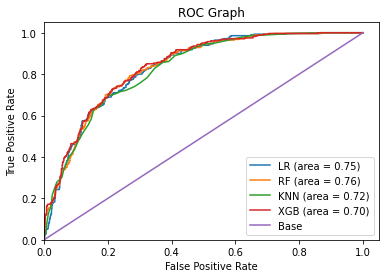

In [70]:
# Create ROC Graph
from sklearn.metrics import roc_curve
lr_fpr, lr_tpr, lr_thresholds = roc_curve(y_test, lr_pipeline.predict_proba(X_test)[:,1])
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, final_rf_model.predict_proba(X_test)[:,1])
knn_fpr, knn_tpr, knn_thresholds = roc_curve(y_test, final_knn_model.predict_proba(X_test)[:,1])
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(y_test, final_xgb_model.predict_proba(X_test)[:,1])

lr_roc_auc = roc_auc_score(y_test, y_pred_lr)
rf_roc_auc = roc_auc_score(y_test, y_pred_rf)
knn_roc_auc = roc_auc_score(y_test, y_pred_knn)
xgb_roc_auc = roc_auc_score(y_test, y_pred_xgb)

plt.figure()

# Plot Logistic Regression ROC
plt.plot(lr_fpr, lr_tpr, label='LR (area = %0.2f)' % lr_roc_auc)

# Plot Random Forest ROC
plt.plot(rf_fpr, rf_tpr, label='RF (area = %0.2f)' % rf_roc_auc)

# Plot K Nearest Neighbors ROC
plt.plot(knn_fpr, knn_tpr, label='KNN (area = %0.2f)' % knn_roc_auc)

# Plot XGboost ROC
plt.plot(xgb_fpr, xgb_tpr, label='XGB (area = %0.2f)' % xgb_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base')

plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right", )
plt.show()